### Binary classification problem with KNN

Inspecting the data set

In [2]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

In [3]:
target.unique()

array(['donated', 'not donated'], dtype=object)

In [4]:
target.value_counts()               # the excat values
target.value_counts(normalize=True) # percentages

not donated    0.762032
donated        0.237968
Name: Class, dtype: float64

### First accuracy score with cross_validate and cross_val_score functions and DummyClassifier

Using a sklearn.dummy.DummyClassifier and the strategy "most_frequent", we determine the average of the accuracy scores obtained by performing a 10-fold cross-validation.

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

model_dummy = DummyClassifier(strategy='most_frequent')   
model_dummy.fit(data, target)

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cv_results = cross_validate(
    model_dummy, data, target, cv=cv)
cv_results['test_score'].mean()

0.7591111111111111

In [6]:
scores = cross_val_score(model_dummy, data, target, cv=cv)
scores.mean()

0.7591111111111111

### Computing the balanced accuracy instead of the accuracy score

In [7]:
scores = cross_val_score(model_dummy, data, target, cv=cv, scoring="balanced_accuracy")
scores.mean()

0.5

### Building the Pipeline: StandardScaler , KNeighborsClassifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data)

model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

### Evaluating the model performance depending on the parameters




### Case 1

We set the parameter n_neighbors=1 and apply a 10-fold cross-validation and use balanced accuracy as a score. 

In [9]:
model_two = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cv_results = cross_validate(
    model_two, data, target, cv=cv, scoring="balanced_accuracy", return_train_score=True)

print(cv_results['train_score'].mean())
print(cv_results['test_score'].mean())
      

0.8913031594986973
0.5982340030485184


### Evaluation: Overfitting model
We see that the gap between train and test scores is large. In addition, the average score on the training sets is good while the average scores on the testing sets are really bad. Those are the signs of an overfitting model.

### Case 2

We will now study the effect of the parameter n_neighbors on the train and test score using a validation curve using a parameter range:

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
Also, we apply a 5-fold cross-validation and compute the balanced accuracy score instead of the default accuracy score.
Finally, we plot the average train and test scores for the different value of the hyperparameter. 

In [10]:
from sklearn.model_selection import validation_curve

model_three = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [11]:
import numpy as np

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
param_n = "kneighborsclassifier__n_neighbors"
train_scores, test_scores = validation_curve(
    model_three, data, target,param_name=param_n, param_range=param_range,
    cv=cv, scoring="balanced_accuracy", n_jobs=2)
mean_train_score = np.mean(train_scores, axis = 1)
mean_train_score

array([0.89130316, 0.83768887, 0.68775401, 0.67351226, 0.66351113,
       0.59719989, 0.50886012, 0.5       , 0.5       ])

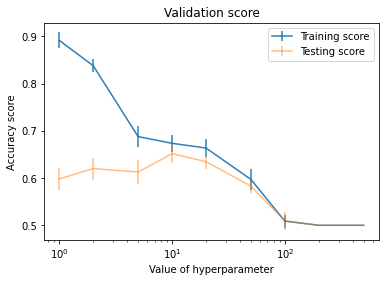

In [13]:
import matplotlib
import matplotlib.pyplot as plt

# First plot
plt.errorbar(
    param_range,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    param_range,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend()
plt.xscale("log")
plt.xlabel(r"Value of hyperparameter")
plt.ylabel("Accuracy score")
_ = plt.title("Validation score")

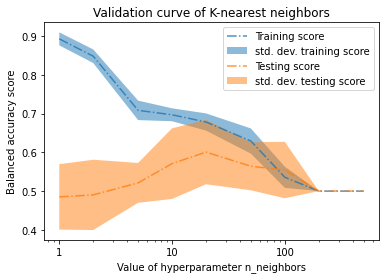

In [15]:
# Second plot
param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
param_name = "kneighborsclassifier__n_neighbors"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=param_range, cv=5,
    n_jobs=2, scoring="balanced_accuracy")

_, ax = plt.subplots()
for name, scores in zip(
    ["Training score", "Testing score"], [train_scores, test_scores]
):
    ax.plot(
        param_range, scores.mean(axis=1), linestyle="-.", label=name,
        alpha=0.8)
    ax.fill_between(
        param_range, scores.mean(axis=1) - scores.std(axis=1),
        scores.mean(axis=1) + scores.std(axis=1),
        alpha=0.5, label=f"std. dev. {name.lower()}")

ax.set_xticks(param_range)
ax.set_xscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel("Value of hyperparameter n_neighbors")
ax.set_ylabel("Balanced accuracy score")
ax.set_title("Validation curve of K-nearest neighbors")
_ = ax.legend(bbox_to_anchor=(1., 1.))

### Evaluation

The model overfits for a range of n_neighbors values between 1 to 10 and underfits for for a range of n_neighbors values between 100 to 500. 

Generalization happens when the gap between train and test scores is relatively low and that the test scores is maximum. In our case, the range between 20 to 50 neighbors seems to be the best. Indeed, for 20 neighbors, the gap between train and test scores is larger than with 50 neighbors; however the test score is better with 20 neighbors.
